# Numerics of Machine Learning
## Exercise Sheet No. 1 — Numerical Linear Algebra

---
University of Tübingen, Winter Term 2022/23
&copy; N. Bosch, P. Hennig, A. Kristiadi, M. Pförtner, J. Schmidt, F. Schneider, L. Tatzel, J. Wenger, 2022 CC BY-NC-SA 3.0

In this week's exercise sheet we will explore the importance of the actual algorithm implementing a mathematical operation and how structure can often be leveraged for efficiency in both time and space. In the second part, we'll implement a basic Gaussian process model using the Cholesky decomposition.

In [2]:
from matplotlib import pyplot as plt
from tueplots import bundles

plt.rcParams.update(bundles.beamer_moml())
plt.rcParams.update({"figure.dpi":200})

## Part 1: Efficient Matrix-Vector Multiplication

Below are a bunch of functions implementing matrix-vector products $x \mapsto Ax$, linear operations similar to ones which appear in most machine learning algorithms. However, all of these matrix-vector products are highly structured and their implementations are far from optimal. Your goal will be to implement them more efficiently by exploiting the structure in the expressions using pure `NumPy` and `SciPy` only.

_Hint:_ We provide you with a timing function that plots the time taken in seconds of each iteration using `timeit`.

**Task**: Implement matrix-vector products with the following (structured) matrices more efficiently.

In [73]:
from typing import List
import numpy as np
import scipy.sparse


def dense_matvec(A: np.ndarray, x: np.ndarray) -> np.ndarray:
    return A @ x  # NOTE: Cannot be improved.


def diag_matvec(Lmbda_diag: np.ndarray, x: np.ndarray) -> np.ndarray:
    return np.diag(Lmbda_diag) @ x


def tridiag_matvec(diags: List[np.ndarray], x: np.ndarray) -> np.ndarray:
    M = np.diag(diags[0], k=-1) + np.diag(diags[1], k=0) + np.diag(diags[2], k=1)
    return M @ x


def low_rank_plus_diag_matvec(
    U: np.ndarray, V: np.ndarray, Lmbda_diag: np.ndarray, x: np.ndarray
) -> np.ndarray:
    Lmbda = np.diag(Lmbda_diag)
    return (U @ V.T + Lmbda) @ x


def compositional_matvec(U: np.ndarray, V: np.ndarray, x: np.ndarray) -> np.ndarray:
    B = np.ones(shape=(U.shape[1], U.shape[1]))
    return U @ B @ V.T @ x


def functional_matvec(
    U: np.ndarray, V: np.ndarray, Lmbda_diag: np.ndarray, x: np.ndarray
) -> np.ndarray:
    return np.linalg.solve(U @ V.T + np.diag(Lmbda_diag), x)


**Task:** Time your implementations. What do you observe when comparing to a dense matrix-vector product?

In [77]:
"""Time for each matrix-vector product as a function of the matrix size n."""

import timeit
import pandas as pd

# Setup
n_max_base = 10
n_max_pow = 3 # NOTE: After optimizing try to raise this exponent to 4 to clearly see large-scale behavior. Whether this is possible may depend on your machine.
n_max = n_max_base**n_max_pow  # Maximum matrix size

# Matrices and vectors
rng = np.random.default_rng(42)
A = rng.uniform(size=(n_max, n_max))
U = rng.uniform(size=(n_max, 10))
V = rng.uniform(size=(n_max, 10))
Lmbda_diag = rng.uniform(size=(n_max,)) + 1.0
diags = lambda n: [
    np.ones(shape=(n - 1,)),
    2 * np.ones(shape=(n,)),
    np.ones(shape=(n - 1,)),
]
x = rng.uniform(size=(n_max,))

# Logging
result_list = []

# Time matrix-vector products
for n in np.logspace(start=1, stop=n_max_pow, base=n_max_base, num=15):
    n = int(np.ceil(n))

    logged_iter = [
        n,
    ]

    for matvec in [
        lambda: dense_matvec(A=A[0:n, 0:n], x=x[0:n]),
        lambda: functional_matvec(
            U=U[0:n, :], V=V[0:n, :], Lmbda_diag=Lmbda_diag[0:n], x=x[0:n]
        ),
        lambda: compositional_matvec(U=U[0:n, :], V=V[0:n, :], x=x[0:n]),
        lambda: low_rank_plus_diag_matvec(
            U=U[0:n, :], V=V[0:n, :], Lmbda_diag=Lmbda_diag[0:n], x=x[0:n]
        ),
        lambda: tridiag_matvec(diags=diags(n), x=x[0:n]),
        lambda: diag_matvec(Lmbda_diag=Lmbda_diag[0:n], x=x[0:n]),
    ]:
        t = timeit.Timer(matvec)
        logged_iter.append(t.timeit(number=100))

    result_list.append(logged_iter)

result_df = pd.DataFrame(
    result_list,
    columns=[
        "n",
        "dense",
        "functional",
        "compositional",
        "low rank + diag",
        "tridiag",
        "diag",
    ],
)


<AxesSubplot: xlabel='n', ylabel='seconds'>

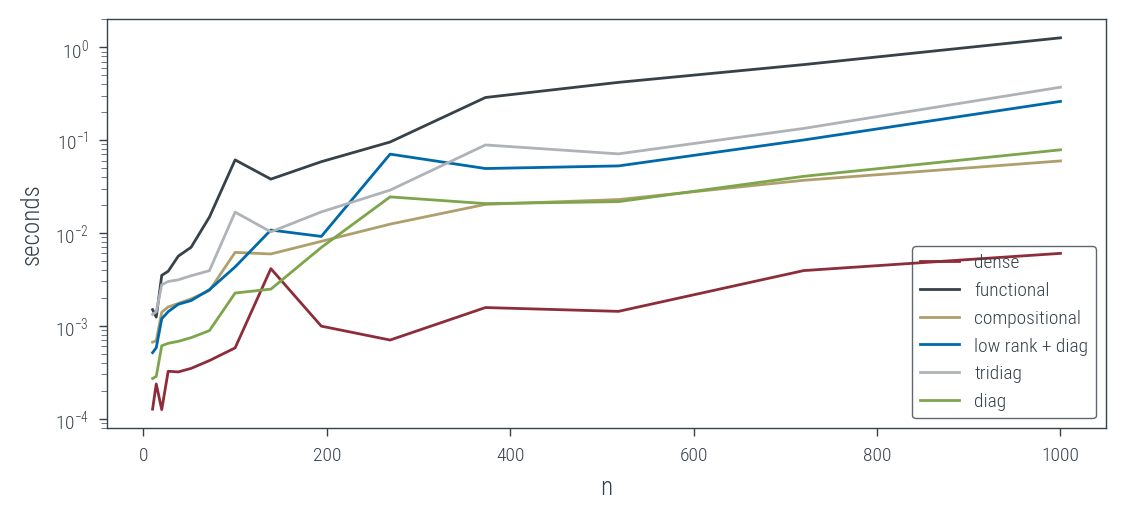

In [78]:
result_df.plot(x="n", ylabel="seconds", logx=False, logy=True)

## Part 2: Gaussian Processes

**Task:** Implement Gaussian process regression via a Cholesky decomposition by completing the class `GaussianProcess` below. Use SciPy's [`cho_factor`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.cho_factor.html#scipy.linalg.cho_factor) and [`cho_solve`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.cho_solve.html#scipy.linalg.cho_solve) to do so.

We provide you with an implementation of random variables, mean functions and kernels via [ProbNum](https://probnum.readthedocs.io/en/latest/index.html). Execute the following cells and if necessary take a look at the documentation to familiarize yourself with how the random variable, mean function and kernel object works.

In [51]:
from probnum.randprocs import kernels
from probnum import functions, randvars

# Create a Gaussian random variable
mu = np.zeros(shape=(2,))
sigma_sq = 2 * np.eye(2)
x = randvars.Normal(mu, sigma_sq)
x.std

array([1.41421356, 1.41421356])

In [52]:
# Create a zero mean function that takes scalars as input and outputs a scalar
meanfun = functions.Zero(input_shape=(), output_shape=())
meanfun(np.linspace(-1, 1, 5))

array([0., 0., 0., 0., 0.])

In [72]:
# Create a Matern kernel encoding (nu - 1/2)-times differentiable functions with scalar input
covfun = kernels.Matern(input_shape=(), nu=1.5)

# Create a synthetic dataset
X = np.linspace(-1, 1, 4)

# Compute the kernel matrix k(X, X)
k_XX = covfun.matrix(X)
print(k_XX)

# Compute the cross-covariance matrix k(x, X)
Y = np.linspace(-0.5, 0.5, 2)
k_YX = covfun(Y[:, None], X[None, :])
print(k_YX)

[[1.         0.67905797 0.3286921  0.13973135]
 [0.67905797 1.         0.67905797 0.3286921 ]
 [0.3286921  0.67905797 1.         0.67905797]
 [0.13973135 0.3286921  0.67905797 1.        ]]
[[0.78488765 0.96554703 0.57695263 0.26775661]
 [0.26775661 0.57695263 0.96554703 0.78488765]]


In [55]:
from scipy.linalg import cho_factor, cho_solve
from typing import Tuple


class GaussianProcess:
    """Gaussian process regression.

    Parameters
    ----------
    mean :
        Mean function.
    cov :
        Covariance function / kernel.
    sigma_sq :
        Scalar observation noise.
    """

    def __init__(
        self, mean: functions.Function, cov: kernels.Kernel, sigma_sq: float = 10**-6
    ):
        self.mean = mean
        self.cov = cov
        self.sigma_sq = sigma_sq
        self.X = None
        self.y = None
        self.Kcholfac = None

    def __call__(self, Xnew: np.ndarray) -> randvars.Normal:
        """Evaluate the Gaussian process at a set of test inputs.
        
        Parameters
        ----------
        Xnew :
            Test inputs.
        """
        prior_mean = self.mean(Xnew)
        prior_cov = self.cov.matrix(Xnew)
        if self.X is None:
            return randvars.Normal(prior_mean, prior_cov)

        post_mean = # TODO
        post_cov = # TODO

        return randvars.Normal(post_mean, post_cov)

    def fit(self, X: np.ndarray, y: np.ndarray)-> "GaussianProcess":
        """Fit the Gaussian process to a training data set.
        
        Parameters
        ----------
        X : 
            Training inputs.
        y :
            Training outputs.
        """
        self.X = X
        self.y = y
        self.Kcholfac = # TODO

        return self

    def log_marginal_likelihood(self) -> float:
        """Log-marginal likelihood of the training data."""
        if self.Kcholfac is None:
            raise ValueError("The Gaussian process has not been fit yet.")
        return # TODO


**Task:** Test your implementation by fitting a Gaussian process to the synthetically generated test data.

In [65]:
rng = np.random.default_rng(42)

# Latent function
f = lambda x: np.sin(2 * np.pi * x)

# Training data
n = 10
X = np.sort(rng.uniform(-1, 1, n))
y = f(X) + 0.1 * rng.normal(size=X.shape[0])


In [ ]:
# Gaussian process
meanfun = functions.Zero(input_shape=())
covfun = kernels.Matern(input_shape=(), nu=1.5, lengthscale=0.2)
g = GaussianProcess(meanfun, covfun, sigma_sq=10**-6)
g.fit(X, y)

Xnew = np.linspace(-1.5, 1.5, 1000)
ypred = g(Xnew)

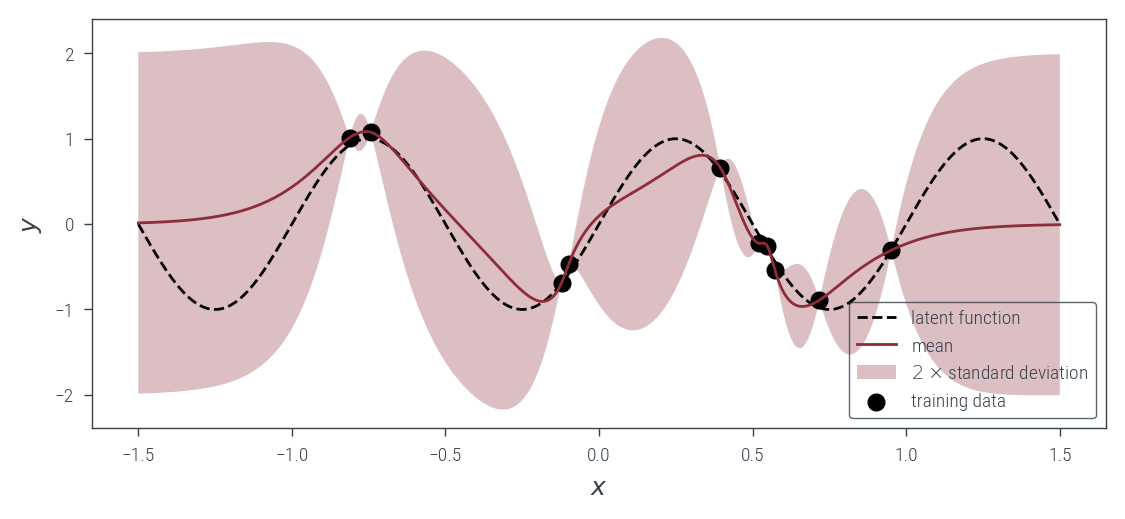

In [ ]:
# Plot
def plot_gp(Xnew, ypred, traindata=None):
    fig, ax = plt.subplots(ncols=1, nrows=1)

    ax.plot(Xnew, f(Xnew), label="latent function", color="k", linestyle="--")
    ax.plot(Xnew, ypred.mean, label="mean")
    ax.fill_between(
        x=Xnew,
        y1=ypred.mean - 2 * ypred.std,
        y2=ypred.mean + 2 * ypred.std,
        alpha=0.3,
        label="$2\\times $standard deviation",
    )

    if traindata is not None:
        ax.scatter(traindata[0], traindata[1], color="k", label="training data")

    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.legend()

    plt.show()


plot_gp(Xnew, ypred, traindata=(X, y))


**Task:** Tune the lengthscale manually by trying to find a large value for the log-marginal likelihood. How does the corresponding fit of the Gaussian process behave?

In [66]:
g.log_marginal_likelihood()


-6.679949641097779

**Task:** What happens when you attempt to fit your GP on a dataset with $n=100,\!000$ datapoints? What's your explanation for the result?

In [68]:
# Training data
n = 10**5
X = np.sort(rng.uniform(-1, 1, n))
y = f(X) + 0.1 * rng.normal(size=X.shape[0])

In [69]:
# Gaussian process
meanfun = functions.Zero(input_shape=())
covfun = kernels.Matern(input_shape=(), nu=1.5, lengthscale=0.2)
g = GaussianProcess(meanfun, covfun, sigma_sq=10**-12)
g.fit(X, y)

MemoryError: Unable to allocate 74.5 GiB for an array with shape (100000, 100000) and data type float64